In [1]:
import tensorflow as tf
import simplejson
import matplotlib.pyplot as plt
%matplotlib inline
import threading
import tensorflow.contrib.slim as slim
from utils import data_utils, train_utils
import datetime
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
import train

In [2]:
hypes = './hypes/hypes.json'
with open(hypes, 'r') as f:
    H = simplejson.load(f)
    H['batch_size'] = 1
    H['pad'] = 100
    H['x_width'] = 3600
    H['x_height'] = 3600
    x_width = H['x_width']
    x_height = H['x_height']
    batch_size = H['batch_size']
    pad = H['pad']

In [3]:
img_data = data_utils.ImageData(32, phase='test')
img_data.load_image()
img_data.create_train_feature()
[img_width, img_height] = img_data.image_size

In [4]:
img_in = tf.placeholder(dtype=tf.float32, shape=[batch_size, x_width, x_height, 16])
logits, pred = train.build_pred(img_in, H, 'test')

In [5]:
feature_w_padding = cv2.copyMakeBorder(
    img_data.train_feature, 
    pad, x_width - pad - img_width, 
    pad, x_height - pad - img_height, 
    cv2.BORDER_REFLECT_101)

In [6]:
feature_w_padding.shape

(3600, 3600, 16)

In [7]:
# config = tf.ConfigProto(device_count = {'GPU': 0})
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, save_path='log_dir/8-15_2-56_combo-jaccard/ckpt/ckpt-12001')
    predictions, log = sess.run([pred, logits], 
                                feed_dict = {img_in: np.reshape(feature_w_padding, 
                                                                [batch_size, x_width, x_height, 16])})

INFO:tensorflow:Restoring parameters from log_dir/8-15_2-56_combo-jaccard/ckpt/ckpt-12001


In [8]:
prd = (predictions > 0.5).astype(int)[pad: pad + img_width, pad: pad + img_height]

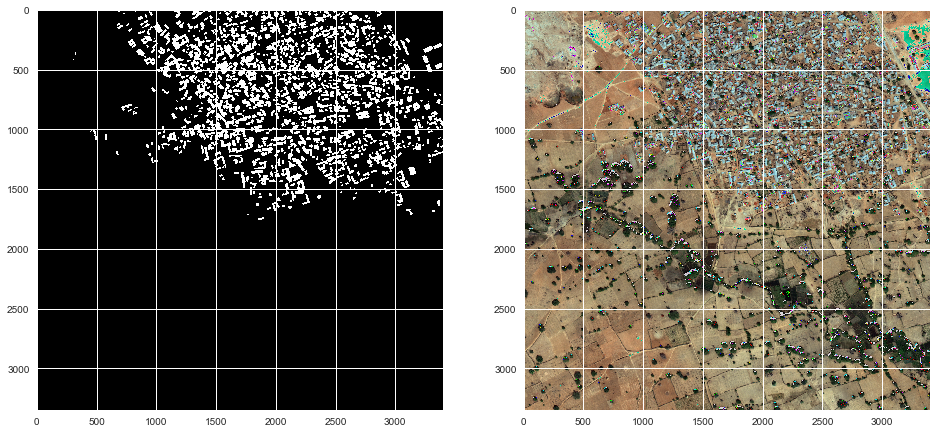

In [9]:
fig, axs = plt.subplots(1,2, figsize = [16, 8])
axs[0].grid(True)
axs[1].grid(True)
axs[0].imshow(prd[:, :], cmap = matplotlib.cm.gray)
axs[1].imshow(data_utils.scale_percentile(img_data.three_band_image[:, :, :]))
axs[1].imshow(prd[:, :], cmap = matplotlib.cm.gray, alpha = 0.1)

In [10]:
np.mean(prd), np.std(prd)

(0.091764610273102232, 0.28869337812726192)

In [11]:
polygon = data_utils.mask_to_polygons(prd)

Self-intersection at or near point 2463.384 1365.72


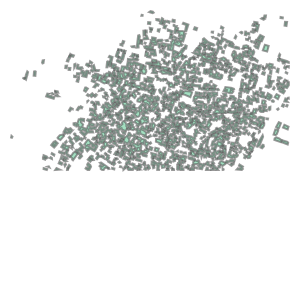

In [12]:
polygon